In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from mlxtend.plotting import scatterplotmatrix
from mlxtend.plotting import heatmap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [3]:

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']
df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt', sep='\t', usecols=columns)
df.head()

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [4]:
df.shape

(2930, 6)

In [5]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [6]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [7]:
df = df.dropna(axis=0)

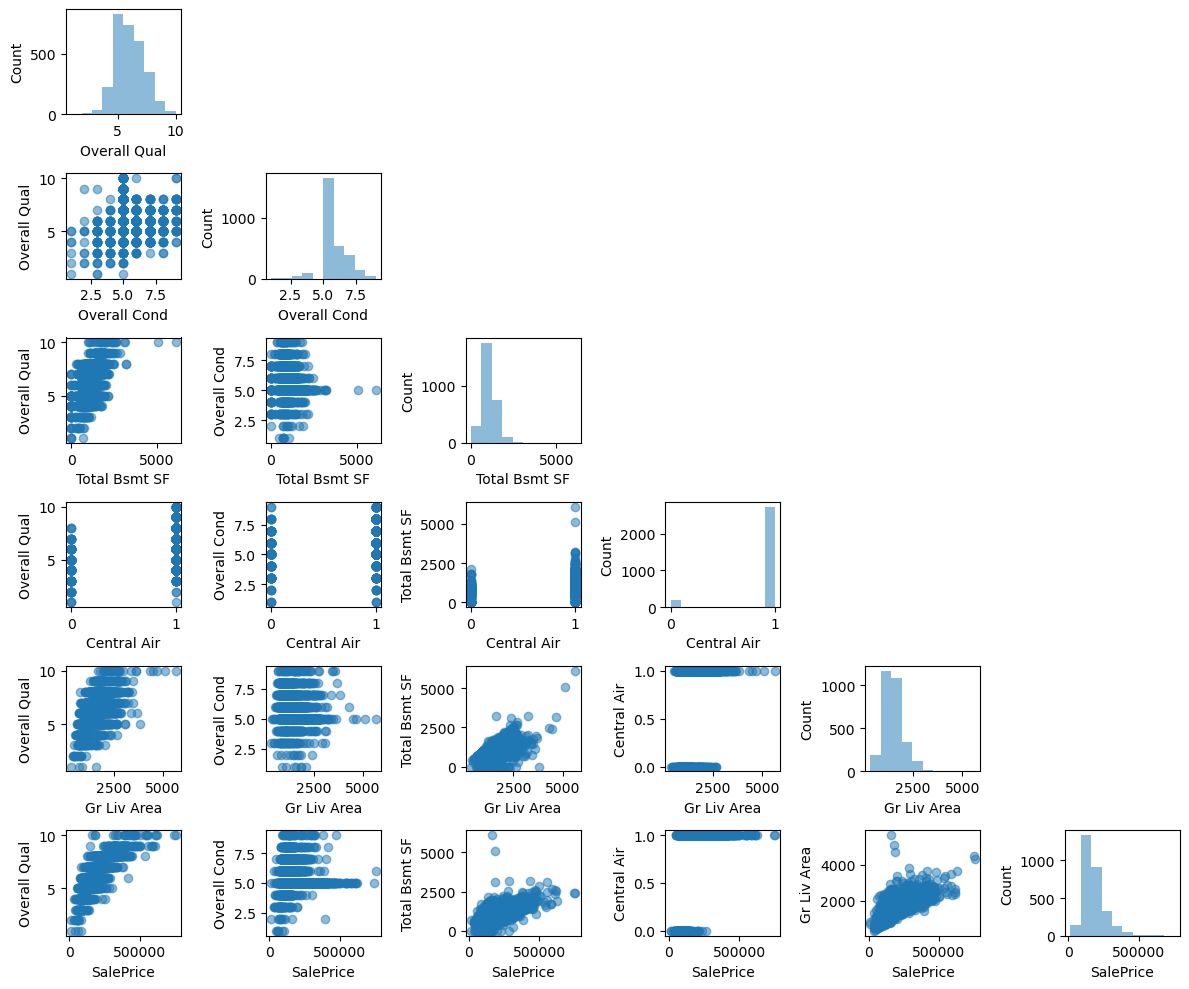

In [18]:
scatterplotmatrix(df.values, figsize=(12, 10), names=df.columns, alpha=0.5)
plt.tight_layout()
plt.show()

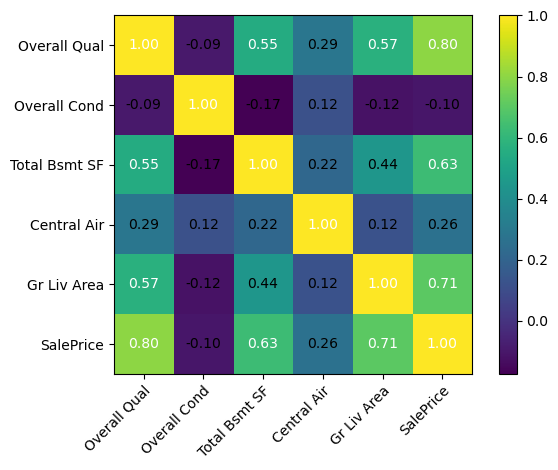

In [22]:
cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

In [27]:
import LinearRegressionGD

In [29]:
X = df[['Gr Liv Area']].values
Y = df['SalePrice'].values
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(Y[:, np.newaxis]).flatten()


In [31]:
lr = LinearRegressionGD.LinearRegression(eta=0.1)
lr.fit(X_std, y_std)

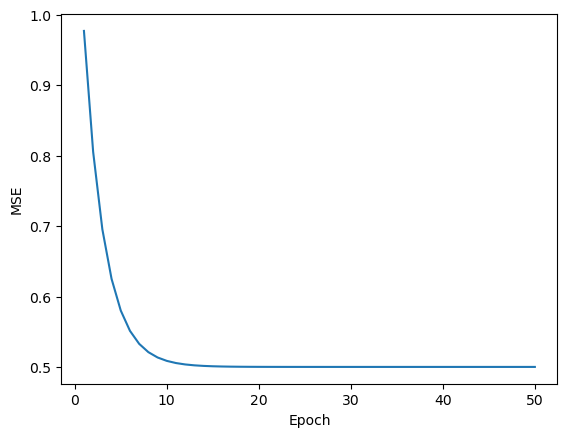

In [33]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.show()

In [35]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)

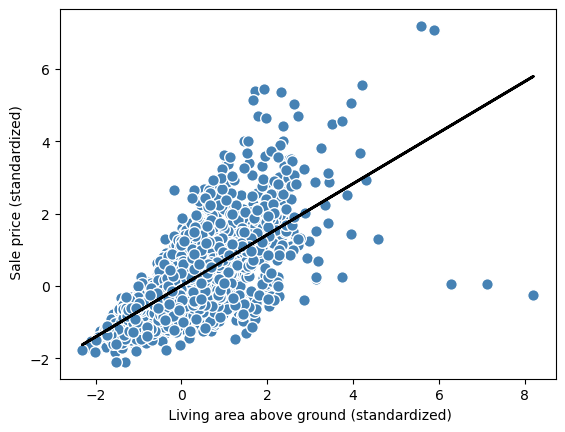

In [37]:
lin_regplot(X_std, y_std, lr)
plt.xlabel(' Living area above ground (standardized)')
plt.ylabel(' Sale price (standardized)')
plt.show()

In [41]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reversed = sc_y.inverse_transform(target_std.reshape(-1, 1))
target_reversed.flatten()[0]

292507.0674366433

In [43]:
lr.w_[0], lr.b_[0]

(0.7066183690732503, -1.5841051773688815e-16)

In [47]:
slr = LinearRegression()
slr.fit(X, Y)
y_pred = slr.predict(X)

In [49]:
slr.coef_[0], slr.intercept_

(111.66625842136438, 13342.978662354843)

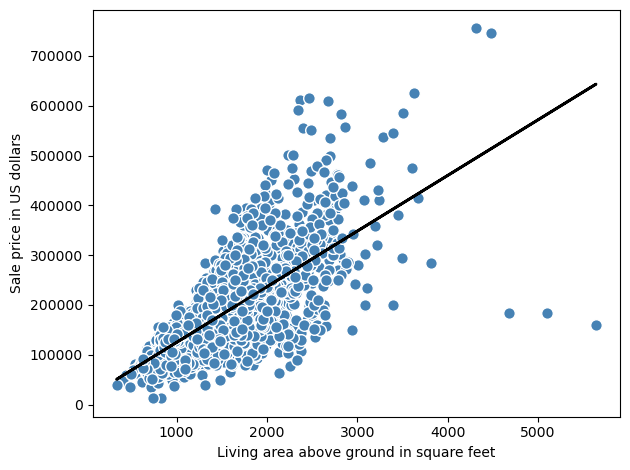

In [51]:
lin_regplot(X, Y, slr)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in US dollars')
plt.tight_layout()
plt.show()

In [56]:
ransac = RANSACRegressor(LinearRegression(), max_trials=100, min_samples=0.95, residual_threshold=None, random_state=123)
ransac.fit(X, Y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

In [58]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

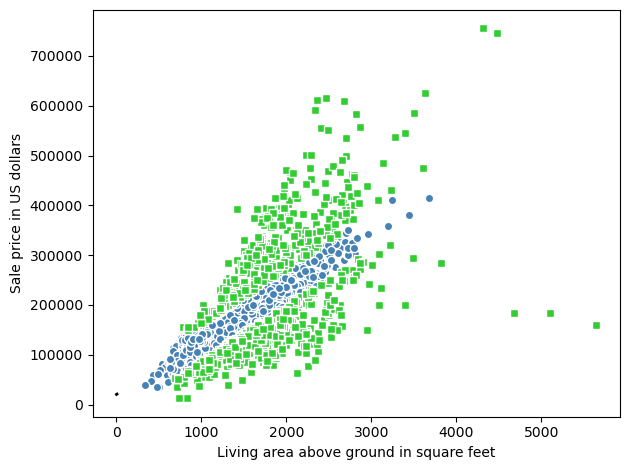

In [60]:
plt.scatter(X[inlier_mask], Y[inlier_mask], c='steelblue', edgecolor='white', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], Y[outlier_mask], c='limegreen', edgecolor='white', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in US dollars')
plt.tight_layout()
plt.show()

In [64]:
ransac.estimator_.coef_[0], ransac.estimator_.intercept_

(106.34799703561399, 20190.092616848968)

In [66]:
np.median(np.abs(Y - np.median(Y)))

37000.0

In [71]:
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [73]:
slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

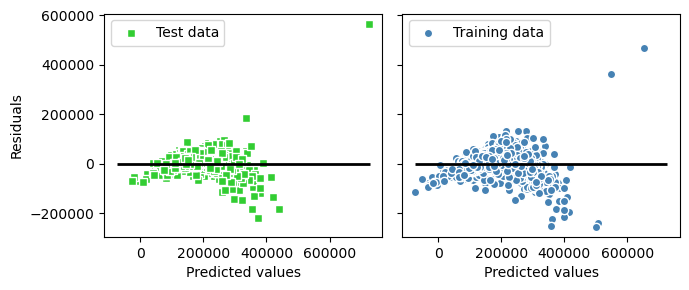

In [77]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()

In [84]:
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mse_train, mse_test

(1497216245.8533978, 1516565820.9990337)

In [86]:
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mae_train, mae_test

(25983.02662399082, 24921.288963945484)

In [90]:
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_r2, test_r2

(0.7694948430504934, 0.7515748205718923)

In [95]:
ridge = Ridge(alpha=1.0)
lasso = Lasso(alpha=1.0)
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

In [107]:
#X = df[['Gr Liv Area']].values
#y = df['SalePrice'].values
#X = X[(df['Gr Liv Area'] < 4000)]
#y = y[(df['Gr Liv Area'] < 4000)]

X = df[['Overall Qual']].values
y = df['SalePrice'].values

regr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)

X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)
X_fit = np.arange(X.min()-1, X.max()+2, 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

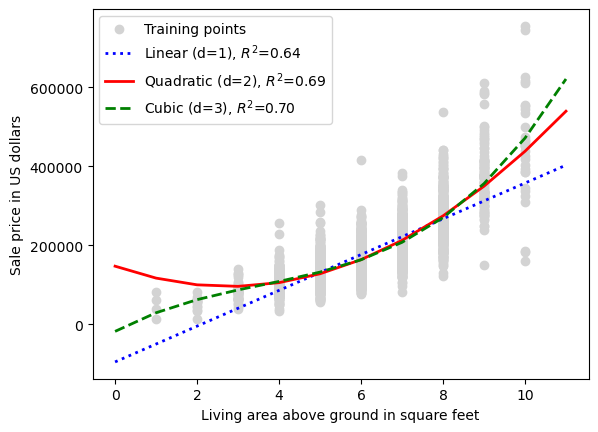

In [109]:
plt.scatter(X, y, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, label=f'Linear (d=1), $R^2$={linear_r2:.2f}', color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}', color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}', color='green', lw=2, linestyle='--')
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in US dollars')
plt.legend(loc='upper left')
plt.show()

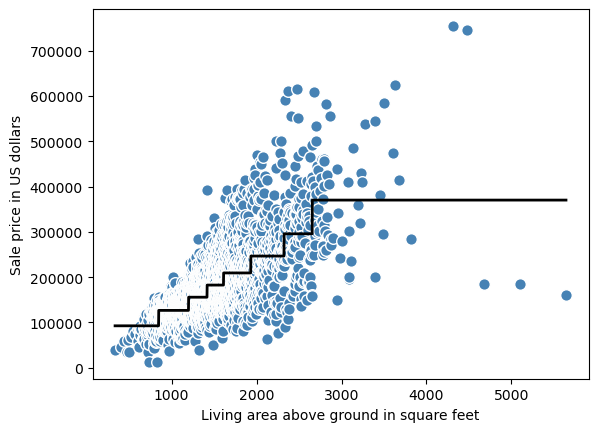

In [114]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()
lin_regplot(X[sort_idx], y[sort_idx], tree)

plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in US dollars')
plt.show()

In [119]:
target = 'SalePrice'
features = df.columns[df.columns != target]
X = df[features].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [121]:
forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error', random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

mae_train, mae_test

(8305.182029324496, 20821.773353102864)

In [123]:
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

r2_train, r2_test

(0.9761478926370749, 0.8470084347901288)

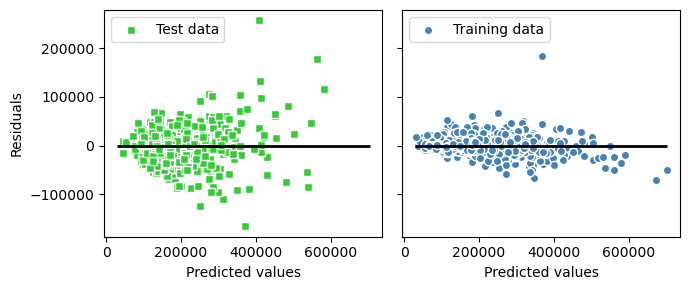

In [125]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, c='limegreen', marker='s', edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, c='steelblue', marker='o', edgecolor='white', label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)
    
plt.tight_layout()
plt.show()